In [1]:
import pandas as pd
import numpy as np
import re
import os
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import wandb
from wandb.integration.keras import WandbCallback
import random
from PIL import Image
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
import matplotlib.pyplot as plt
#API KEY: b660489761915cbeae2e964a70f9a20b9ec4d250

2025-05-15 08:56:27.890571: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-15 08:56:27.935913: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-15 08:56:27.935936: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-15 08:56:27.937052: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-15 08:56:27.944181: I tensorflow/core/platform/cpu_feature_guar

In [2]:
#data = pd.read_csv("/Lab3_Data/flickr8k/captions.txt")
class WandBBLEUCallback(Callback):

    def on_epoch_end(self, epoch, logs=None):
        wandb.log({
                "epoch": epoch + 1,
                "train_loss": logs.get("loss"),
                "val_loss": logs.get("val_loss"),
                "val_accuracy": logs.get("val_accuracy")
            })

In [3]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
# Disable all GPUs
#tf.config.set_visible_devices([], 'GPU')

# Optional: confirm only CPU is used
#logical_devices = tf.config.list_logical_devices()
#print("Logical devices:", logical_devices)




# Load image path and caption data
image_path = '/Lab3_Data/flickr8k/Images'
data = pd.read_csv("/Lab3_Data/flickr8k/captions.txt")



# Preprocessing text

def text_preprocessing(caption):
    caption = caption.lower()
    caption = re.sub(r'[^a-z\s]', '', caption)                 # Remove non-letter characters
    caption = re.sub(r'\s+', ' ', caption).strip()             # Normalize whitespace
    caption = ' '.join([word for word in caption.split() if len(word) > 1 or word in ['a', 'i']])
    caption = 'startseq ' + caption + ' endseq'                # Add start/end tokens
    return caption

image_file_name = []
allLines = {}


with open("/Lab3_Data/flickr8k/captions.txt", 'r') as file:
    for line in file:
        if line == 'image,caption\n':
            continue
        lineList = line.split(',')
        
        if lineList[0] not in image_file_name:
            image_file_name.append(lineList[0])
            allLines[lineList[0]] = [text_preprocessing(lineList[1])]
        else:
            allLines[lineList[0]].append(text_preprocessing(lineList[1]))


keys = list(allLines.keys())
random.shuffle(keys)

n = len(keys)

valBegin = int(0.7*n)
valEnd = int(0.9*n)


trainLabel = keys[:valBegin] 
valLabel = keys[valBegin:valEnd]
testLabel = keys[valEnd:]


trainData = {}
valData = {}
testData = {}

for x in trainLabel:
    trainData[x] = allLines[x]
for x in valLabel:
    valData[x] = allLines[x]
for x in testLabel:
    testData[x] = allLines[x]



# ==== Tokenizer & Max Length ====
#tokenizer = Tokenizer()
#tokenizer.fit_on_texts(train_data['caption'].tolist()) # ?
#vocab_size = len(tokenizer.word_index) + 1 # Input size for the agent.
#max_length = max(len(c.split()) for c in data['caption']) #Used for padding to make all captions same size.

# Flatten all captions from trainData
all_train_captions = []
for captions in trainData.values():
    all_train_captions.extend(captions)

# Fit tokenizer on all training captions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_train_captions)

# Vocabulary size
vocab_size = len(tokenizer.word_index) + 1

# Compute max caption length
max_length = max(len(caption.split()) for caption in all_train_captions)




# Load and preprocess images
def readImage(path, img_size=224):
    img = load_img(path, color_mode='rgb', target_size=(img_size, img_size))
    img = img_to_array(img) # reshape the image to an array
    img = preprocess_input(img) # Prepare the input for the VGG16?
    return img





# Extract image features using VGG16
base_model = VGG16(weights='imagenet')
model_vgg = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)

# Map from filename to VGG features
image_features = {}
for img_name in tqdm(data['image'].unique()):
    img_path = os.path.join(image_path, img_name)
    img = readImage(img_path) # Load in images
    img = np.expand_dims(img, axis=0) # 
    feature = model_vgg.predict(img, verbose=0) #
    feature = feature.reshape(-1) # 
    image_features[img_name] = feature # Image features





Num GPUs Available: 1


2025-05-15 08:56:37.080314: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9797 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:22:00.0, compute capability: 7.5
100%|██████████| 8091/8091 [08:36<00:00, 15.67it/s]


In [4]:
# Prepare training data
#def data_generator(df, tokenizer, max_length, image_features, vocab_size, batch_size):
 #   while True:
  #      for i in range(0, len(df), batch_size):
   #         batch = df.iloc[i:i+batch_size]
    #        X1, X2, y = [], [], []
     #       for _, row in batch.iterrows():
      #          caption = row['caption']
       #         img_name = row['image']
        #        seq = tokenizer.texts_to_sequences([caption])[0]
         #       img_feature = image_features[img_name]
#
 #               for j in range(1, len(seq)):
  #                  in_seq, out_seq = seq[:j], seq[j]
   #                 in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
    #                out_seq = tf.keras.utils.to_categorical(out_seq, num_classes=vocab_size)
     #               X1.append(img_feature)
      #              X2.append(in_seq)
       #             y.append(out_seq)
        #    yield (np.array(X1), np.array(X2)), np.array(y)

def data_generator(data_dict, tokenizer, max_length, image_features, vocab_size, batch_size):
    image_keys = list(data_dict.keys())
    while True:
        random.shuffle(image_keys)
        for i in range(0, len(image_keys), batch_size):
            X1, X2, y = [], [], []
            batch_keys = image_keys[i:i+batch_size]
            for img_name in batch_keys:
                captions = data_dict[img_name]
                img_feature = image_features.get(img_name)
                if img_feature is None:
                    continue  # skip if image features are missing
                
                for caption in captions:
                    seq = tokenizer.texts_to_sequences([caption])[0]
                    for j in range(1, len(seq)):
                        in_seq, out_seq = seq[:j], seq[j]
                        in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                        out_seq = tf.keras.utils.to_categorical(out_seq, num_classes=vocab_size)
                        X1.append(img_feature)
                        X2.append(in_seq)
                        y.append(out_seq)
            yield (np.array(X1), np.array(X2)), np.array(y)




# ==== Build the Model ====
image_input = Input(shape=(4096,))
image_dense = Dense(256, activation='relu')(image_input)

caption_input = Input(shape=(max_length,))
caption_embed = Embedding(vocab_size, 256, input_length=max_length)(caption_input)
caption_lstm = LSTM(256)(caption_embed)

decoder = add([image_dense, caption_lstm])
decoder = Dense(256, activation='relu')(decoder)
output = Dense(vocab_size, activation='softmax')(decoder)

model = Model(inputs=[image_input, caption_input], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), )

# ==== Train the Model ====
batch_size = 64
steps_per_epoch = len(trainData) // batch_size
val_steps = len(valData) // batch_size

train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(trainData, tokenizer, max_length, image_features, vocab_size, batch_size),
    output_signature=(
        (tf.TensorSpec(shape=(None, 4096), dtype=tf.float32),
         tf.TensorSpec(shape=(None, max_length), dtype=tf.int32)),
        tf.TensorSpec(shape=(None, vocab_size), dtype=tf.float32)
    )
)

val_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(valData, tokenizer, max_length, image_features, vocab_size, batch_size),
    output_signature=(
        (tf.TensorSpec(shape=(None, 4096), dtype=tf.float32),
         tf.TensorSpec(shape=(None, max_length), dtype=tf.int32)),
        tf.TensorSpec(shape=(None, vocab_size), dtype=tf.float32)
    )
)

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    'best_model.h5',           # The file where the best model will be saved
    monitor='val_loss',        # The metric to monitor (use 'val_accuracy' or other metrics as needed)
    save_best_only=True,       # Only save the model if it is the best (based on the monitored metric)
    mode='min',                # 'min' means the best model will have the minimum validation loss (change to 'max' for accuracy)
    verbose=1                  # Prints info when saving the model
)



wandb.init(
    project="image-captioning",  # your project name
    name="Run2",  # this run's name
    config={
        "epochs": 10,
        "batch_size": batch_size,
        "learning_rate": 0.001,
        "model": "VGG + LSTM",
        "max_length": max_length,
        "vocab_size": vocab_size
    }
)


model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_steps=val_steps,
    callbacks=[
        WandbCallback(),
        WandBBLEUCallback(),
        checkpoint
    ]
)

wandb: Currently logged in as: m00n (ertveh-4-lule-university-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: WARNING WandbCallback is deprecated and will be removed in a future release. Please use the WandbMetricsLogger, WandbModelCheckpoint, and WandbEvalCallback callbacks instead. See https://docs.wandb.ai/guides/integrations/keras for more information.
wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/10


2025-05-15 09:05:29.945542: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fc7fd423200 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-05-15 09:05:29.945585: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2025-05-15 09:05:29.969756: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747292730.119502 3267222 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


88/88 [==============================] - ETA: 0s - loss: 5.3458

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /wandb/run-20250515_090526-ofn3774e/files/model-best/assets


INFO:tensorflow:Assets written to: /wandb/run-20250515_090526-ofn3774e/files/model-best/assets
wandb: Adding directory to artifact (/wandb/run-20250515_090526-ofn3774e/files/model-best)... Done. 0.2s



Epoch 1: val_loss improved from inf to 4.59028, saving model to best_model.h5
88/88 [==============================] - 33s 336ms/step - loss: 5.3458 - val_loss: 4.5903
Epoch 2/10


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


88/88 [==============================] - ETA: 0s - loss: 4.1294INFO:tensorflow:Assets written to: /wandb/run-20250515_090526-ofn3774e/files/model-best/assets


INFO:tensorflow:Assets written to: /wandb/run-20250515_090526-ofn3774e/files/model-best/assets
wandb: Adding directory to artifact (/wandb/run-20250515_090526-ofn3774e/files/model-best)... Done. 0.2s



Epoch 2: val_loss improved from 4.59028 to 3.77375, saving model to best_model.h5


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


88/88 [==============================] - 29s 325ms/step - loss: 4.1294 - val_loss: 3.7738
Epoch 3/10
88/88 [==============================] - ETA: 0s - loss: 3.4271INFO:tensorflow:Assets written to: /wandb/run-20250515_090526-ofn3774e/files/model-best/assets


INFO:tensorflow:Assets written to: /wandb/run-20250515_090526-ofn3774e/files/model-best/assets
wandb: Adding directory to artifact (/wandb/run-20250515_090526-ofn3774e/files/model-best)... Done. 0.2s



Epoch 3: val_loss improved from 3.77375 to 3.48175, saving model to best_model.h5


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


88/88 [==============================] - 34s 384ms/step - loss: 3.4271 - val_loss: 3.4818
Epoch 4/10
88/88 [==============================] - ETA: 0s - loss: 3.0396INFO:tensorflow:Assets written to: /wandb/run-20250515_090526-ofn3774e/files/model-best/assets


INFO:tensorflow:Assets written to: /wandb/run-20250515_090526-ofn3774e/files/model-best/assets
wandb: Adding directory to artifact (/wandb/run-20250515_090526-ofn3774e/files/model-best)... Done. 0.3s



Epoch 4: val_loss improved from 3.48175 to 3.40136, saving model to best_model.h5


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


88/88 [==============================] - 42s 479ms/step - loss: 3.0396 - val_loss: 3.4014
Epoch 5/10
88/88 [==============================] - ETA: 0s - loss: 2.7690INFO:tensorflow:Assets written to: /wandb/run-20250515_090526-ofn3774e/files/model-best/assets


INFO:tensorflow:Assets written to: /wandb/run-20250515_090526-ofn3774e/files/model-best/assets
wandb: Adding directory to artifact (/wandb/run-20250515_090526-ofn3774e/files/model-best)... Done. 0.2s



Epoch 5: val_loss improved from 3.40136 to 3.37537, saving model to best_model.h5


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


88/88 [==============================] - 36s 415ms/step - loss: 2.7690 - val_loss: 3.3754
Epoch 6/10
88/88 [==============================] - ETA: 0s - loss: 2.5585
Epoch 6: val_loss did not improve from 3.37537
88/88 [==============================] - 31s 350ms/step - loss: 2.5585 - val_loss: 3.4015
Epoch 7/10
88/88 [==============================] - ETA: 0s - loss: 2.4043
Epoch 7: val_loss did not improve from 3.37537
88/88 [==============================] - 31s 359ms/step - loss: 2.4043 - val_loss: 3.4163
Epoch 8/10
88/88 [==============================] - ETA: 0s - loss: 2.2885
Epoch 8: val_loss did not improve from 3.37537
88/88 [==============================] - 30s 346ms/step - loss: 2.2885 - val_loss: 3.4365
Epoch 9/10
88/88 [==============================] - ETA: 0s - loss: 2.1880
Epoch 9: val_loss did not improve from 3.37537
88/88 [==============================] - 30s 342ms/step - loss: 2.1880 - val_loss: 3.4782
Epoch 10/10
88/88 [==============================] - ETA: 0s -

In [5]:
def generate_caption(model, tokenizer, photo_feature, max_length):
    in_text = 'startseq'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = tf.keras.preprocessing.sequence.pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo_feature, sequence], verbose=0)
        yhat = tf.argmax(yhat[0]).numpy()
        word = tokenizer.index_word.get(yhat)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text

def test_random_example(test_data, image_features, model, tokenizer, max_length, image_dir):
    # Pick a random image filename from the test data
    image_filename = random.choice(list(test_data.keys()))
    
    # Load and show image
    image_path = os.path.join(image_dir, image_filename)
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    # Get corresponding feature vector
    photo_feature = image_features[image_filename]
    photo_feature = np.expand_dims(photo_feature, axis=0)

    # Generate caption
    generated_caption = generate_caption(model, tokenizer, photo_feature, max_length)

    # Print generated caption
    print("Generated Caption:", generated_caption)

    # Get reference captions (clean and split into words)
    references = [caption.split()[1:-1] for caption in test_data[image_filename]]
    candidate = generated_caption.split()[1:-1]
    print(candidate)
    # Compute BLEU score
    smoothie = SmoothingFunction().method4
    bleu = sentence_bleu(references, candidate, smoothing_function=smoothie)

    print("BLEU Score:", round(bleu, 4))
    print("References:", references)

In [6]:
testModel = load_model('best_model.h5')

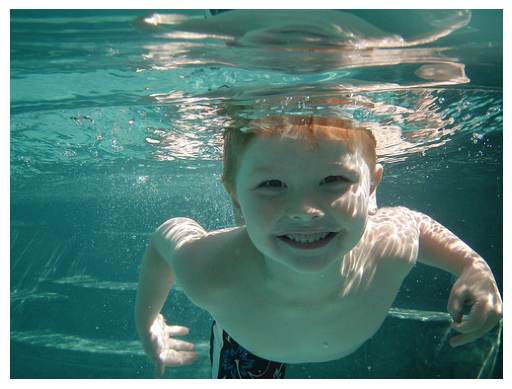

Generated Caption: startseq a small boy in swimming pool endseq
['a', 'small', 'boy', 'in', 'swimming', 'pool']
BLEU Score: 0.278
References: [['a', 'boy', 'smiles', 'underwater'], ['a', 'redheaded', 'boy', 'swimming', 'underwater'], ['a', 'small', 'boy', 'swimming', 'underwater'], ['a', 'smiling', 'boy', 'swims', 'underwater', 'in', 'a', 'pool'], ['the', 'boys', 'smiles', 'underwater', 'at', 'the', 'pool']]


In [12]:


test_random_example(
    test_data=testData,
    image_features=image_features,
    model=testModel,
    tokenizer=tokenizer,
    max_length=max_length,
    image_dir="Lab3_Data/flickr8k/Images"
)